<a href="https://colab.research.google.com/github/tomonari-masada/course2021-sml/blob/main/06_linear_regression_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実データの単回帰分析

## description vs prediction 

今回は、単回帰をpredictionにではなくdescriptionに使う。

* description＝与えられたデータを理解する

* prediction＝未知の入力について出力を求めたい（機械学習の主戦場）

* explanation＝因果関係の理解まで含む

https://www.slideshare.net/gshmueli/to-explain-to-predict-or-to-describe


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 今回参考にした本

Laura Igual and Santi Seguí. *Introduction to Data Science: A Python Approach to Concepts, Techniques and Applications.* Springer, 2017.

https://link.springer.com/book/10.1007%2F978-3-319-50017-1

# 使用するデータ
* 北半球と南半球の海氷域面積を分析し、面積が減少傾向にあるのかどうかを調べてみる。（上の本の6.2.1節より。）
 * 単回帰なので線形トレンドを調べるだけ。
 * Rでは`notrend_test`という関数を使えばよいらしい。

* データは、下記の場所から取得。

 * https://nsidc.org/data/seaice_index/archives


 * 以下の2つのファイルをダウンロードしておく。
  *   [北極域の海氷域面積データ](ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv)
  *   [南極域の海氷域面積データ](ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v3.0.csv)



# 線形トレンドの分析

### 1) データファイルを読み込んで前処理をする

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* 北半球のデータを扱う（南半球のデータは自習）

In [3]:
n_ice = pd.read_csv('/content/drive/MyDrive/2021Courses/SML/N_seaice_extent_daily_v3.0.csv')
n_ice.shape

(13896, 6)

In [4]:
n_ice.head()

,Year,Month,Day,Extent,Missing,Source Data
0,YYYY,MM,DD,10^6 sq km,10^6 sq km,Source data product web sites: http://nsidc.o...
1,1978,10,26,10.231,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...
2,1978,10,28,10.420,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...
3,1978,10,30,10.557,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...
4,1978,11,01,10.670,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...


* 必ずしも毎日のデータがあるわけではないことが分かる。（例：1978年10月27日のデータはない。）

* 最初の行はデータのフォーマットの説明なので、消す。

In [5]:
n_ice = n_ice.drop(0, axis=0)

In [6]:
n_ice.head()

,Year,Month,Day,Extent,Missing,Source Data
1,1978,10,26,10.231,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...
2,1978,10,28,10.420,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...
3,1978,10,30,10.557,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...
4,1978,11,01,10.670,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...
5,1978,11,03,10.777,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.03/nt_19...


In [7]:
n_ice.tail()

,Year,Month,Day,Extent,Missing,Source Data
13891,2021,05,16,12.746,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.05.15/nt_202...
13892,2021,05,17,12.731,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.05.16/nt_202...
13893,2021,05,18,12.682,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.05.17/nt_202...
13894,2021,05,19,12.624,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.05.18/nt_202...
13895,2021,05,20,12.601,0.000,['/ecs/DP1/PM/NSIDC-0081.001/2021.05.19/nt_202...


In [8]:
n_ice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13895 entries, 1 to 13895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          13895 non-null  object
 1    Month        13895 non-null  object
 2    Day          13895 non-null  object
 3        Extent   13895 non-null  object
 4       Missing   13895 non-null  object
 5    Source Data  13895 non-null  object
dtypes: object(6)
memory usage: 759.9+ KB


* 1978年と2021年は一年分のデータがないので、消す。

In [9]:
n_ice = n_ice[(n_ice.Year != '1978') & (n_ice.Year != '2021')]

In [10]:
n_ice.head()

,Year,Month,Day,Extent,Missing,Source Data
35,1979,01,02,14.997,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.02/nt_19...
36,1979,01,04,14.922,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.04/nt_19...
37,1979,01,06,14.929,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.06/nt_19...
38,1979,01,08,14.968,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.08/nt_19...
39,1979,01,10,15.190,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.10/nt_19...


In [11]:
n_ice.tail()

,Year,Month,Day,Extent,Missing,Source Data
13753,2020,12,27,12.579,0.000,['/ecs/DP1/PM/NSIDC-0051.001/2020.12.27/nt_20...
13754,2020,12,28,12.582,0.000,['/ecs/DP1/PM/NSIDC-0051.001/2020.12.28/nt_20...
13755,2020,12,29,12.608,0.000,['/ecs/DP1/PM/NSIDC-0051.001/2020.12.29/nt_20...
13756,2020,12,30,12.622,0.000,['/ecs/DP1/PM/NSIDC-0051.001/2020.12.30/nt_20...
13757,2020,12,31,12.639,0.000,['/ecs/DP1/PM/NSIDC-0051.001/2020.12.31/nt_20...


* indexを打ち直す

In [12]:
n_ice.reset_index(drop=True, inplace=True)
n_ice.head()

,Year,Month,Day,Extent,Missing,Source Data
0,1979,01,02,14.997,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.02/nt_19...
1,1979,01,04,14.922,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.04/nt_19...
2,1979,01,06,14.929,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.06/nt_19...
3,1979,01,08,14.968,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.08/nt_19...
4,1979,01,10,15.190,0.000,['/ecs/DP1/PM/NSIDC-0051.001/1979.01.10/nt_19...


In [13]:
n_ice.describe()

,Year,Month,Day,Extent,Missing,Source Data
count,13723,13723,13723,13723,13723,13723
unique,42,12,31,7863,1,13723
top,1996,10,27,14.404,0.000,['/ecs/DP1/PM/NSIDC-0051.001/2020.07.05/nt_20...
freq,366,1178,452,9,13723,1


In [14]:
n_ice.columns

Index(['Year', ' Month', ' Day', '     Extent', '    Missing', ' Source Data'], dtype='object')

* 列名の文字列に空白があるので除去する。

In [15]:
n_ice.columns = n_ice.columns.str.strip()
n_ice.columns

Index(['Year', 'Month', 'Day', 'Extent', 'Missing', 'Source Data'], dtype='object')

* 必要な列だけ残す

In [16]:
n_ice = n_ice.drop(['Missing', 'Source Data'], axis=1)

In [17]:
n_ice.head()

,Year,Month,Day,Extent
0,1979,01,02,14.997
1,1979,01,04,14.922
2,1979,01,06,14.929
3,1979,01,08,14.968
4,1979,01,10,15.190


In [18]:
n_ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13723 entries, 0 to 13722
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    13723 non-null  object
 1   Month   13723 non-null  object
 2   Day     13723 non-null  object
 3   Extent  13723 non-null  object
dtypes: object(4)
memory usage: 429.0+ KB


* 海氷域面積を浮動小数点数に変換する

In [19]:
n_ice['Extent'] = n_ice['Extent'].astype(float)
n_ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13723 entries, 0 to 13722
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    13723 non-null  object 
 1   Month   13723 non-null  object 
 2   Day     13723 non-null  object 
 3   Extent  13723 non-null  float64
dtypes: float64(1), object(3)
memory usage: 429.0+ KB


* 単純にプロットしてみる。
 

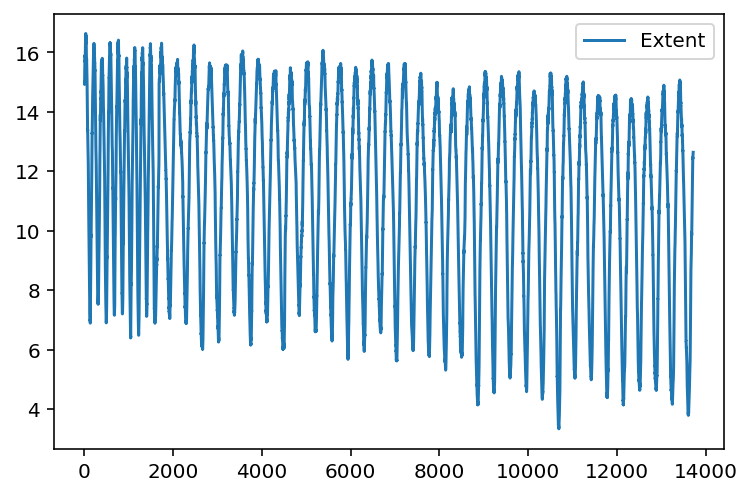

In [20]:
n_ice.plot()

* 最初の方は2日おきにしかデータが無く、グラフの様子が少し違うので、修正。

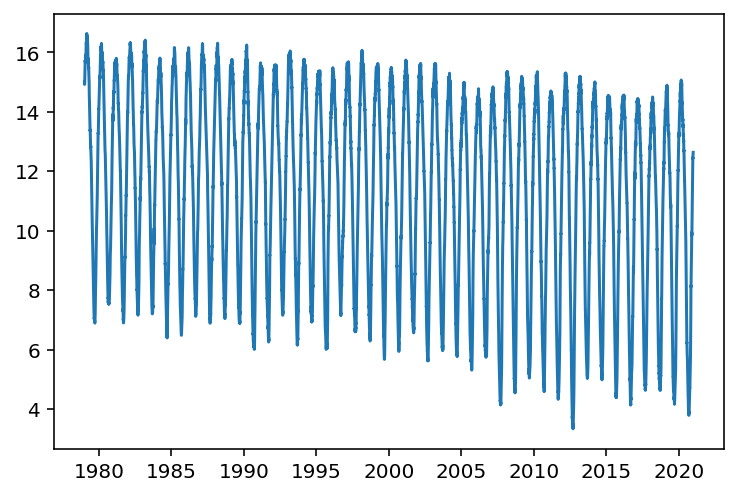

In [21]:
plt.plot(pd.to_datetime(n_ice[['Year', 'Month', 'Day']]), n_ice.Extent)

* 下降トレンドはありそう。
* 周期性があり、非常に目立つ。
 * 以下は、この周期性を消去する一つの試み。（これが唯一の正解というわけではない。）

### 2) 一ヶ月ごとにデータをまとめて、平均をとる
* データを日単位では見ないことにする。
 * 日単位で細かくデータを見て線形のトレンドを分析したい場合は、各自、試みてください。

In [22]:
n_ice_grouped = n_ice.groupby(['Year', 'Month'], as_index=False)

In [23]:
n_ice_monthly = n_ice_grouped.mean()[['Year', 'Month', 'Extent']]
n_ice_monthly.head()

,Year,Month,Extent
0,1979,01,15.414000
1,1979,02,16.175286
2,1979,03,16.341938
3,1979,04,15.446800
4,1979,05,13.856867


In [24]:
# 変数名を付け直す
n_ice = n_ice_monthly

* 横軸は年にし、同じ年のデータは縦方向にまとめてプロットしてみる。

Text(0, 0.5, 'Extent')

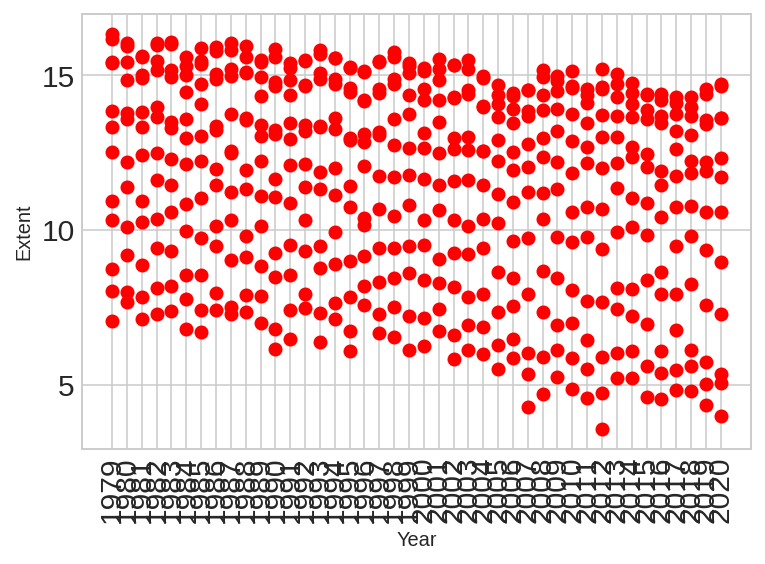

In [25]:
plt.style.use('seaborn-whitegrid')
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15) 
plt.rc('font', size=20) 
plt.rc('figure', figsize=(16, 7))

x = n_ice.Year
y = n_ice.Extent
plt.scatter(x, y, color='red')
plt.xlabel('Year')
plt.ylabel('Extent')

* どうやら、一年の内で、かなり値が変動するらしい。

* 一年の内での変化が目立ち過ぎて、全体的な変化が分かりにくい。

### 3) 一年間の範囲内での変化のパターンを可視化する

* 散布図で、年の違いを横断して、各月ごとに面積データを可視化する。
* 面積データに季節性があるかどうかを確認する。

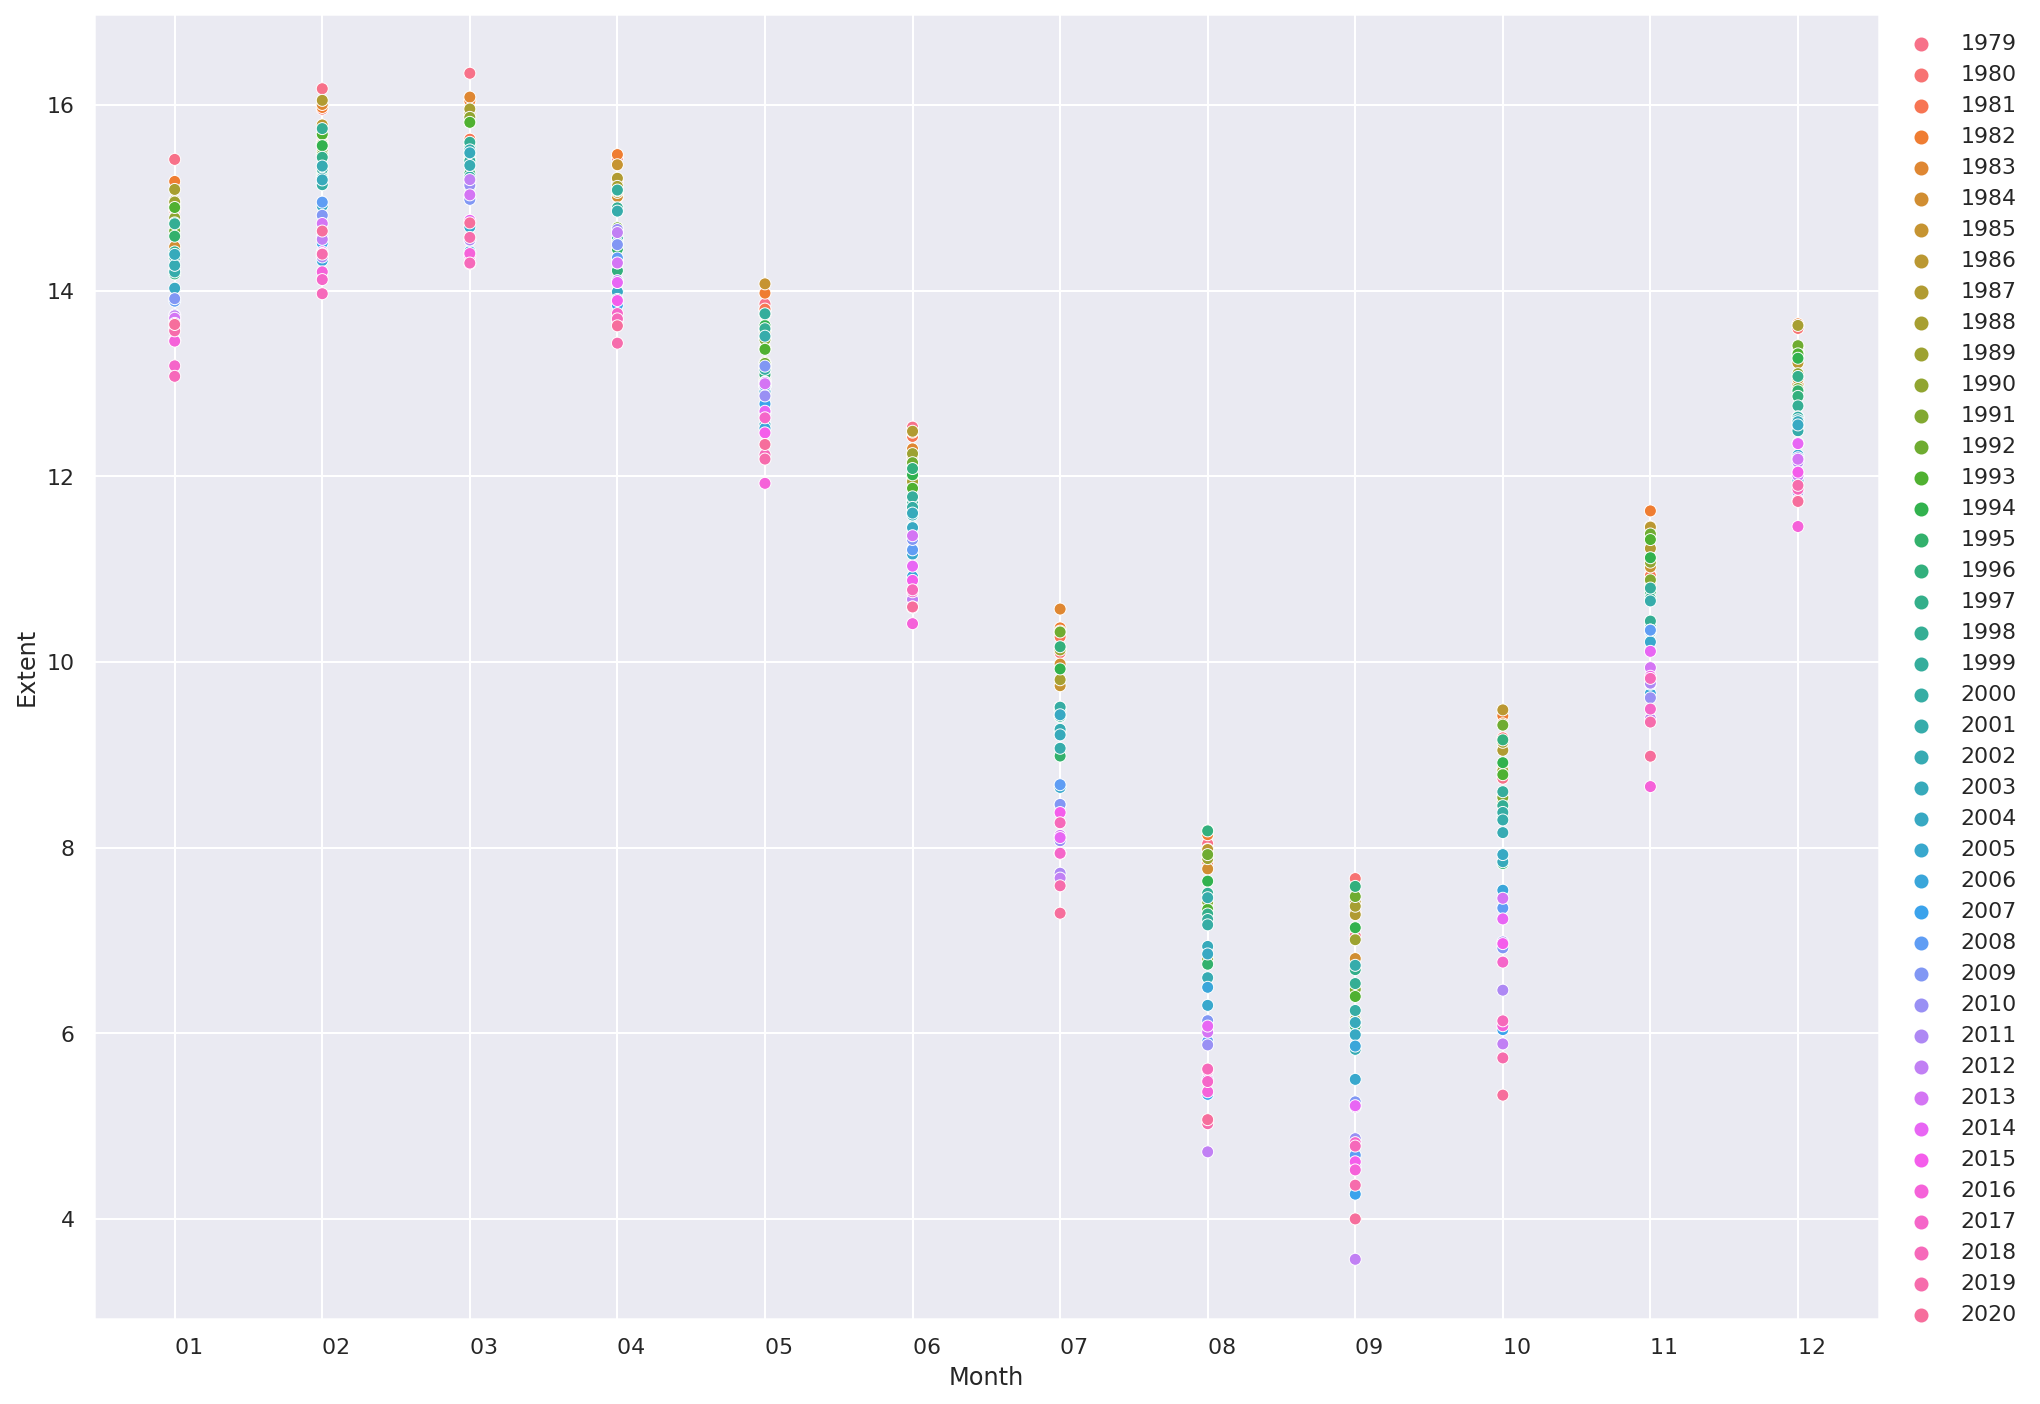

In [26]:
sns.set(rc={'figure.figsize':(16,12)})
sns.scatterplot(x="Month", y="Extent", hue="Year", data=n_ice)
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("IceExtentByMonth.png", bbox_inches='tight')

* 一年間の内で、はっきりした周期的な変化パターンがあることがわかる。
* つまり、「この月は、だいたいこのぐらい値」という値があることが分かる。
 * 異なる月の面積をそのまま比較するのは難しそう。

### 4) 一年間の範囲内に見られる変化パターンを取り除く

* 各月のデータの、すべての年にわたる平均と標準偏差を求める。

In [27]:
grouped = n_ice.groupby('Month')
month_means = grouped.Extent.mean()
month_stds = grouped.Extent.std()

In [28]:
month_means

Month
    01    14.253411
    02    15.117744
    03    15.271608
    04    14.541253
    05    13.128614
    06    11.559180
    07     9.131564
    08     6.815174
    09     6.018397
    10     7.914987
    11    10.445752
    12    12.648899
Name: Extent, dtype: float64

In [29]:
month_stds

Month
    01    0.608231
    02    0.601605
    03    0.558504
    04    0.558224
    05    0.519611
    06    0.620571
    07    0.938964
    08    1.034068
    09    1.146803
    10    1.157624
    11    0.743983
    12    0.604973
Name: Extent, dtype: float64

* 月ごとにz値へ変換する。
 * この計算を、標準化(standardization)と呼ぶ。
 * 平均を引いて標準偏差で割ったものをz値と呼ぶ。
 * この計算をした後のデータは、平均が0、標準偏差が1になる。

In [30]:
n_ice_original = n_ice.copy()

In [31]:
for month in n_ice.Month.unique():
  idx = n_ice.Month == month
  z_values = (n_ice['Extent'][idx] - month_means[month]) / month_stds[month]
  n_ice['Extent'][idx] = z_values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


* z値に変換したので、改めて、年の違いを横断して、各月ごとに面積データを可視化する。

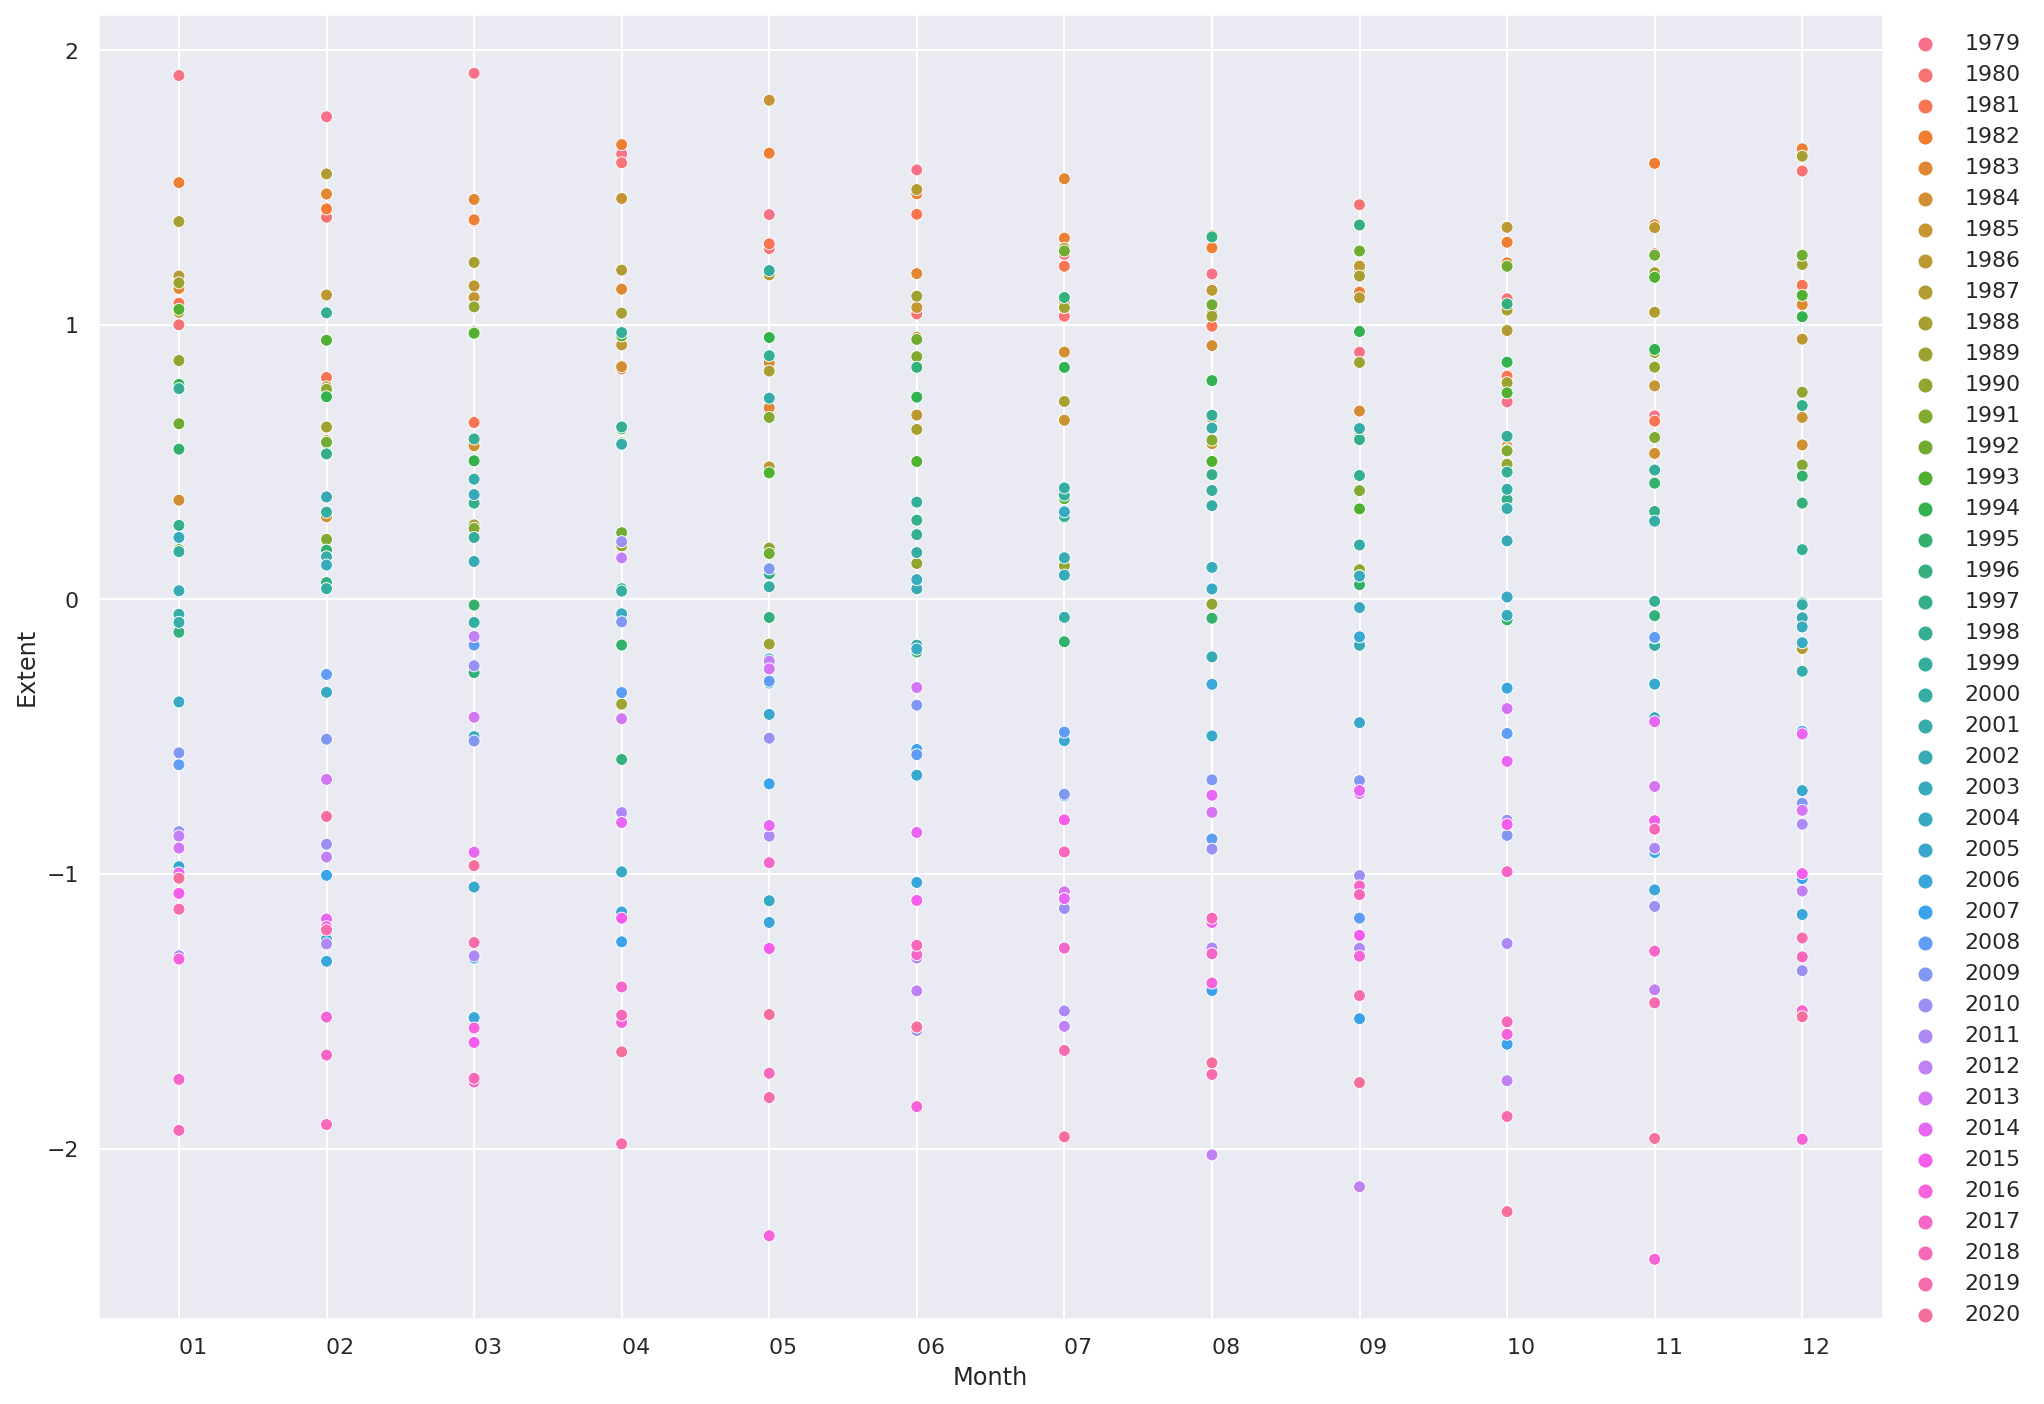

In [32]:
sns.set(rc={'figure.figsize':(16,12)})
sns.scatterplot(x="Month", y="Extent", hue="Year", data=n_ice)
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("IceExtentZscoreByMonth.png", bbox_inches='tight')

### 5) 全範囲での変化の様子を改めて見る

* 各月の個性は、すでに消した。
* その上で、全範囲での変化の様子を改めて見る
 * seabornの単回帰のプロットを利用する。

* Yearを整数にしておく
 * 以下、1年経つとどのくらい変化するか、という分析をする。

In [33]:
n_ice.Year = n_ice.Year.astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


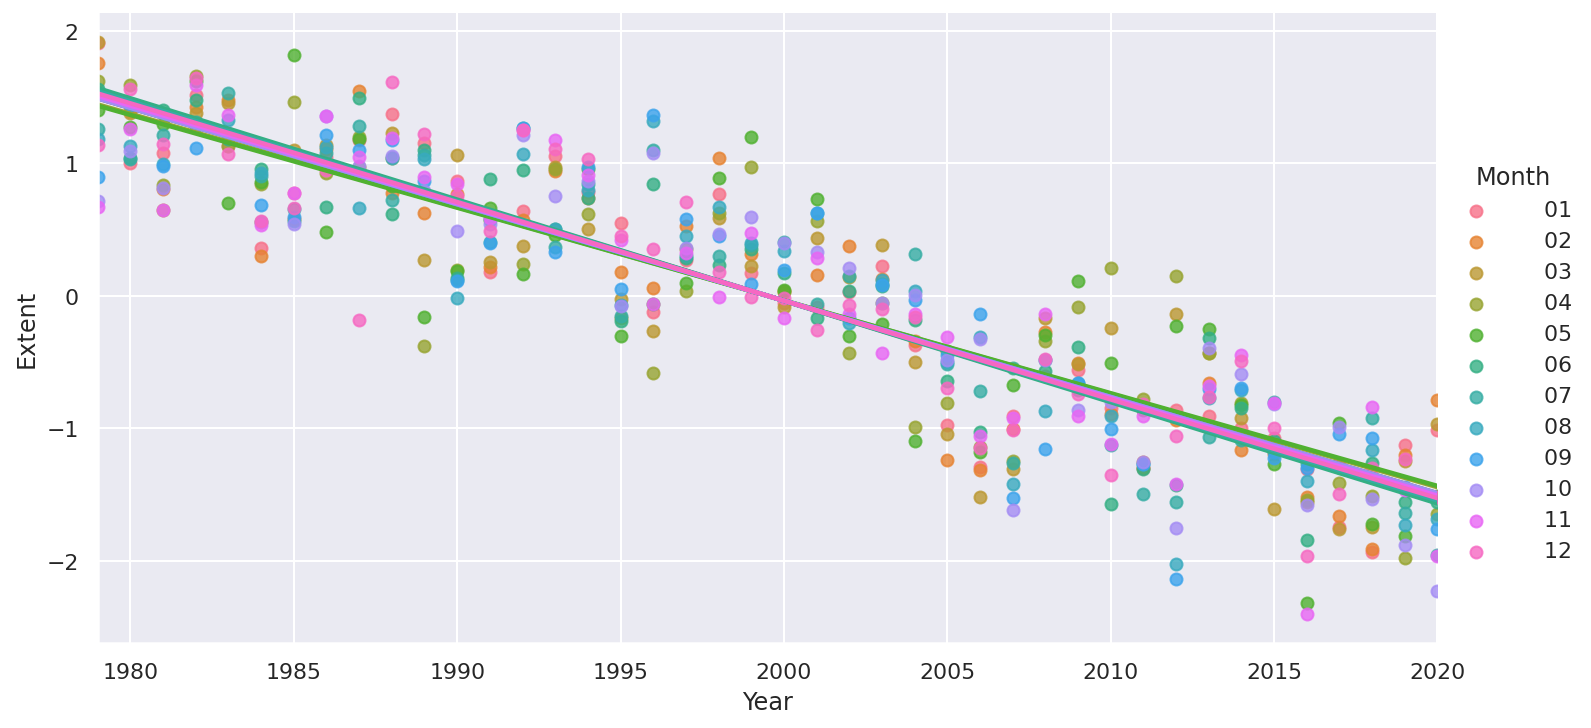

In [34]:
sns.lmplot("Year", "Extent", n_ice, hue="Month", ci=None, aspect=2)
plt.savefig("IceExtentAllMonthsByYearlmplot.png", bbox_inches='tight')

* 直線でfittingしても、悪くなさそう。
* そして、面積減少の傾向が見て取れる。
 * どの月の直線も、ほとんど同じ傾き。


* ピアソンの相関係数と、無相関の検定のp値を求める。

In [35]:
for month in n_ice.Month.unique():
  x = n_ice[n_ice.Month == month].Year.values
  y = n_ice[n_ice.Month == month].Extent.values
  coef, pval = sp.stats.pearsonr(x, y)
  print(f'{month}\t{coef:.3f}\t{pval:.3e}')

    01	-0.930	5.505e-19
    02	-0.908	1.000e-16
    03	-0.892	2.291e-15
    04	-0.865	1.571e-13
    05	-0.859	3.334e-13
    06	-0.938	4.695e-20
    07	-0.924	2.547e-18
    08	-0.908	1.005e-16
    09	-0.893	2.018e-15
    10	-0.893	2.054e-15
    11	-0.903	2.759e-16
    12	-0.914	2.673e-17


### 6) sklearnの線形回帰を使った分析
* 今回は、機械学習をするのではないので、予測はしない。
* 回帰直線を単に求めるだけ。
 * 予測をするときは、訓練データと検証データとテストデータに分割する必要がある。

* sklearnの`LinearRegression`で、回帰直線を求める。
 * 傾きを表示する。
 * 切片はそのまま表示せず、代わりに1979年の位置での値を表示する。

In [36]:
reg = LinearRegression()

for month in n_ice.Month.unique():
  x = n_ice[n_ice.Month == month].Year.values
  y = n_ice[n_ice.Month == month].Extent.values
  reg.fit(x.reshape(-1, 1), y)
  coef = reg.coef_[0]
  intercept = reg.coef_[0] * 1979 + reg.intercept_
  print(f'{month}\t{coef:.4f}\t{intercept:.2f} ({reg.intercept_:.1f})')

    01	-0.0758	1.55 (151.6)
    02	-0.0740	1.52 (148.0)
    03	-0.0727	1.49 (145.4)
    04	-0.0705	1.44 (140.9)
    05	-0.0700	1.44 (140.0)
    06	-0.0765	1.57 (152.9)
    07	-0.0753	1.54 (150.6)
    08	-0.0740	1.52 (148.0)
    09	-0.0728	1.49 (145.5)
    10	-0.0728	1.49 (145.5)
    11	-0.0736	1.51 (147.2)
    12	-0.0745	1.53 (149.0)


* 一年ごとの変化量は、各月の標準偏差を掛け算すれば面積値に戻せる。


In [37]:
for month in n_ice.Month.unique():
  x = n_ice[n_ice.Month == month].Year.values
  y = n_ice[n_ice.Month == month].Extent.values
  reg.fit(x.reshape(-1, 1), y)
  coef = reg.coef_[0] * month_stds[month]
  intercept = reg.coef_[0] * 1979 + reg.intercept_
  intercept = intercept * month_stds[month] + month_means[month]
  print(f'{month}\t{coef:.4f}\t{intercept:.2f}')

    01	-0.0461	15.20
    02	-0.0445	16.03
    03	-0.0406	16.10
    04	-0.0393	15.35
    05	-0.0364	13.87
    06	-0.0475	12.53
    07	-0.0707	10.58
    08	-0.0766	8.38
    09	-0.0834	7.73
    10	-0.0842	9.64
    11	-0.0548	11.57
    12	-0.0451	13.57


* この結果は、元の面積値データで、月毎にseabornで回帰直線を描けば、確認できる。

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


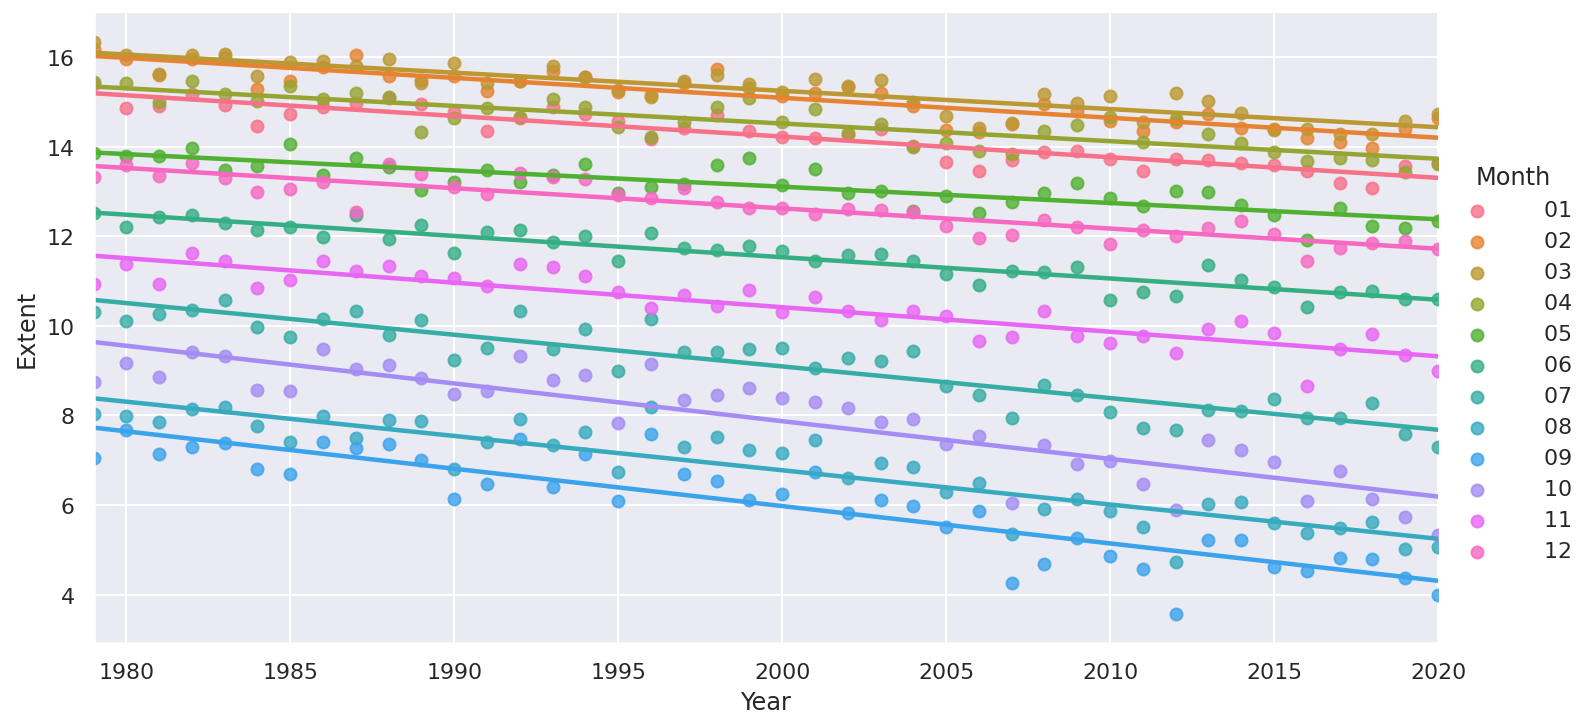

In [38]:
n_ice_original.Year = n_ice_original.Year.astype(int)
sns.lmplot("Year", "Extent", n_ice_original, hue="Month", ci=None, aspect=2)

* 元々の面積値を月毎に見ても、上図のようにまとまりがない。
* このバラバラ感をなくすことを、月毎に標準化するという方法で、行ったのだった。

* フィッティングの評価
 *   mean squared error (MSE)
 *   the coefficient of determination ($R^2$)



* $R^2$は$(1 - \textbf{u}/\textbf{v})$と定義される。

 * $\textbf{u}$ は残差の二乗和 $\sum (\textbf{y} - \hat{\textbf{y}})^2$。（$\hat{\textbf{y}}$が回帰による予測値。）

 * $\textbf{v}$ は、真値の平均$\bar{\textbf{y}}$ からの個々の真値$\textbf{y}$のズレの二乗の和$\sum (\textbf{y} - \bar{\textbf{y}})^2$。

 * $R^2$の最も良い値は1.0。これより小さくなるほど悪くなる。

In [39]:
reg = LinearRegression()

for month in n_ice.Month.unique():
  x = n_ice[n_ice.Month == month].Year.values
  y = n_ice[n_ice.Month == month].Extent.values
  reg.fit(x.reshape(-1,1), y)

  y_hat = reg.predict(x.reshape(-1,1))
  mse = metrics.mean_squared_error(y, y_hat)
  score = metrics.r2_score(y, y_hat)
  print(f"{month}\tMSE:{mse:.3f}\tR^2:{score:.3f}")

    01	MSE:0.132	R^2:0.865
    02	MSE:0.171	R^2:0.825
    03	MSE:0.200	R^2:0.795
    04	MSE:0.246	R^2:0.748
    05	MSE:0.256	R^2:0.738
    06	MSE:0.117	R^2:0.881
    07	MSE:0.142	R^2:0.854
    08	MSE:0.171	R^2:0.825
    09	MSE:0.198	R^2:0.797
    10	MSE:0.199	R^2:0.797
    11	MSE:0.180	R^2:0.816
    12	MSE:0.160	R^2:0.836


どうやら、データは長期的なnegative trendを示している、と言ってもよさそう。


### 7) statsmodelsの線形回帰を使った分析

* こちらのほうが、統計学的な観点からの分析に向いている。
 * 検定ができるから。


In [40]:
results = dict()

for month in n_ice.Month.unique():
  x = n_ice[n_ice.Month == month].Year.values
  x_ = sm.add_constant(x) # 切片を追加
  y = n_ice[n_ice.Month == month].Extent.values
  model = sm.OLS(y, x_)
  results[month] = model.fit()

In [41]:
results.keys()

dict_keys(['    01', '    02', '    03', '    04', '    05', '    06', '    07', '    08', '    09', '    10', '    11', '    12'])

* statsmodelsはこのsummaryが強力。

In [42]:
results['    01'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     256.1
Date:                Fri, 21 May 2021   Prob (F-statistic):           5.50e-19
Time:                        16:55:31   Log-Likelihood:                -17.052
No. Observations:                  42   AIC:                             38.10
Df Residuals:                      40   BIC:                             41.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.5786      9.472     16.003      0.000     132.435     170.722
x1            -0.0758      0.005    -16.003      0.000      -0.085      -0.066
==============================================================================
Omnibus:                        1.642   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.440   Jarque-Bera (JB):                1.583
Skew:                          -0.400   Prob(JB):                        0.453
Kurtosis:                       2.484   Cond. No.                     3.30e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 課題6
南極海氷域について、同様に分析をしてみよう。

